# STAT3105 Flight Delay Prediction Final Project Fall 2021
# Jafar Vohra (jv2775)

## Code:

### Pipeline: Part 1 - Data Reading, Cleaning, and Splitting 

In [12]:
# imports and installs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install catboost
from catboost import CatBoostRegressor, Pool

# data reading
flights = pd.read_csv("/content/pnwflights14.csv")
test = pd.read_csv("/content/test_student.csv")

# data cleaning
flights = flights[(flights.dep_time >= 0) & (flights.air_time >= 0) & (flights.distance >= 0)]
flights = flights.dropna()
x = flights[['month','dep_time','dep_delay','arr_time','carrier','origin','dest','air_time','distance']]
ID = test['Id']
test = test[['month','dep_time','dep_delay','arr_time','carrier','origin','dest','air_time','distance']]

# RMSLE minimizer conversion
y = flights.arr_delay
y_min = min(y)
y_max = max(y)
y = np.log((y-y_min)/(y_max-y_min) + 1)

# train/validation dataset splitting
x_train, x_validation, y_train, y_validation = train_test_split(x, y, train_size=0.8, random_state=1234)
categorical_features_indices = np.where(x.dtypes != np.float)[0]
train_dataset = Pool(x_train, y_train, categorical_features_indices)

### Pipeline: Part 2 - Model Creation, Parameter Tuning, and Model Fitting

In [14]:
# model creation
model=CatBoostRegressor(loss_function='RMSE',iterations=1000, learning_rate=0.4, depth=11, l2_leaf_reg=0.1)

# parameter tuning
#grid = {'iterations': [100,150],
        #'learning_rate': [0.4,0.5],
        #'depth': [8,11],
        #'l2_leaf_reg': [0.1,0.2]}
#model.grid_search(grid, train_dataset)

# model fitting
model.fit(x_train, y_train,cat_features=categorical_features_indices,eval_set=(x_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0121070	test: 0.0127367	best: 0.0127367 (0)	total: 717ms	remaining: 11m 56s
1:	learn: 0.0093895	test: 0.0097905	best: 0.0097905 (1)	total: 1.27s	remaining: 10m 33s
2:	learn: 0.0080520	test: 0.0082971	best: 0.0082971 (2)	total: 1.98s	remaining: 10m 56s
3:	learn: 0.0073558	test: 0.0076423	best: 0.0076423 (3)	total: 2.56s	remaining: 10m 37s
4:	learn: 0.0069750	test: 0.0072882	best: 0.0072882 (4)	total: 3.13s	remaining: 10m 22s
5:	learn: 0.0066706	test: 0.0069928	best: 0.0069928 (5)	total: 3.57s	remaining: 9m 51s
6:	learn: 0.0065295	test: 0.0068596	best: 0.0068596 (6)	total: 4.05s	remaining: 9m 35s
7:	learn: 0.0063813	test: 0.0067249	best: 0.0067249 (7)	total: 4.7s	remaining: 9m 42s
8:	learn: 0.0062065	test: 0.0065820	best: 0.0065820 (8)	total: 5.3s	remaining: 9m 44s
9:	learn: 0.0060235	test: 0.0064085	best: 0.0064085 (9)	total: 5.75s	remaining: 9m 29s
10:	learn: 0.0058598	test: 0.0062595	best: 0.0062595 (10)	total: 6.1s	remaining: 9m 8s
11:	learn: 0.0057573	test: 0.0061586	bes

### Pipeline: Part 3 - Predictions and Submission Creation

In [15]:
# prediction creation
predictions = model.predict(test)

# RMSLE minimizer conversion
predictions = np.exp(predictions)
def convert(x):
  return((x-1)*(y_max-y_min)+y_min)
vfunc = np.vectorize(convert)
predictions = vfunc(predictions)

# submission creation
submission = pd.DataFrame()
submission['Id'] = ID
submission['arr_delay'] = predictions
submission.to_csv("CatBoostSubmission.csv", index=False)

In [21]:
submission.head()

,Id,arr_delay
0,201401010001-PDX-ANC-N508AS,83.062901
1,201401010034-SEA-ANC-N762AS,35.025507
2,201401010614-SEA-SNA-N607AS,-1.064930
3,201401010648-SEA-MSP-N419AS,-14.156879
4,201401010650-SEA-PHX-N626AW,76.356035


## Report:

### Pipeline Description

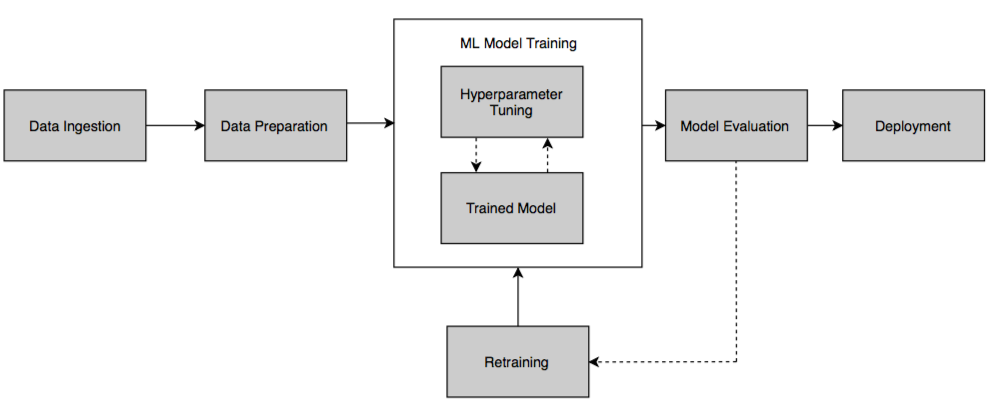

In order to begin, a few modules were imported to allow for an expanded range of methods and functions to aid throughout the process. Those like pandas and numpy are widely used modules that allow for more efficient data analysis techniques. The sklearn.modelselection module is typically used for splitting datasets into training and testing sets like it is utilized here. To use the regression algorithm in this pipeline, it was necessary to install the package before importing it. All of these added modules made the process much easier and quicker, as well as more understandable to someone who may want to recreate this pipeline. 

The initial portion of the pipeline began by reading in the training and test data from the CSV files provided. It was then necessary to clean the training data as there were NA values residing in many different rows of data and in various columns. There were were also many negative values for ones that should strictly be positive, such as distance, departure time, and air time. I used one dataframe filtering technique that kept only the positive values for the necessary time and distance features as well as another to remove the NA values from the features that had them. Following the data cleaning process, the dataframes were subsetted to include only the features that would be used in the regression process. Since the goal of this project is to minimize the RMSLE and not the RMSE like most regression algorithms aim to do, it was in my best interest to use a technique to scale the data by a logorithmic factor. This was done just before the final step in the data preparation process, splitting the training data into testing and validating sets so that the model could be tested for overfitting. The data was split 80/20 between testing and validation in this process. The locations of the categorical data features that would be used in the model were also noted for when the model will be fitted later. Fortunately, the regression algorithm that was used in this pipeline tested for overfitting while training the model, so that part was included in the model fitting portion of the process.

The next part of the pipeline included the model creation, parameter tuning, and model fitting. It starts by the actual creation of the model with the CatBoostRegressor() function from the catboost module that was imported at the very start. In the code above, the tuned hyperparameters are included in the model, however the commented lines below the created model were where the process of hyperparameter tuning took place. Attempting numerous values for each of the listed hyperparameters, the grid_search() function would fit the model to the training dataset with each combination of hyperparameters that were used in the grid. After testing on different folds of the training dataset for validation, the best hyperparamters would be printed and could be used in further testing, or used in the model. Once the trials and testing of the hyperparamters was complete, the best ones were used in the final model creation. The model was then fitted to the training dataset, being mindful of where the categorical features were located, and evaluated on the validation set for overfitting. The output of the model as it learned also included the output of the model evaluating for overfitting on the validation dataset. If the model were to be overfitted at a certain iteration, the model would be shrunk to that iteration before the predictions were created.

The final portion of the pipeline is where the predictions were made and the submission in the correct format for the Kaggle Competition was created. Using the predict() function, our fitted model was used to predict the values of arrival delay on the test dataset. Yielding a numpy array, this data was then converted back to its original scale with the vectorized one-dimensional function. After conversion, the final submission dataframe was created in the format necessary to make a submission to the Kaggle competition. This dataframe was then written to a CSV file to be downloaded and submitted. Once submitted, the predictions that I made resulted in a RMSLE of 0.46951, good for 3rd on the public leaderboard with approximately 50% of the data used.

### Pipeline Selection and Improvement Process

After using a linear model and the lm() command in R in my previous attempt at this project, I decided to use a boosting algorithm in order to make even more improvements and yield an even lower RMSLE. This boosted algorithm is called CatBoostRegressor() from the catboost module. I chose this specific model as it allowed for the use of categorical features as well as numerical features seamlessly. This model also had numerous hyperparameters that could be tuned in order to allow the model to perform much better. When I first fitted this model on the training dataset without tuning or specifiying any of the hyperparamters, the RMSLE was more than twice the value of the RMSLE of the fitted model that was tuned. The hyperparameter tuning makes a significant difference, but to keep it as simple as possible, I chose to tune 4 of the most important hyperparameters of this model, iterations, learning rate, tree depth, and L2 regularization. As mentioned before, the grid_search() function was used to try each of the hyperparameter combinations defined in the grid. Once each was fitted and validated, the best combination would be displayed and was then used for further tuning. Although this process was tedious, eventually a point was reached where small changes above and below the hyperparameter values made no improvements, thus our model was fully tuned. There are more hyperparameters that could be tuned and improve my model further such as random strength, bagging temperature, and border count, but for simplicity and time reasons, only the four most important were tuned.

One of the biggest difference between my final submission for this project and the one made for HW5 is that my previous submission was coded in R while this one was coded in python. I found that when working with models more sophisticated than the lm() function, the process of hyperparameter tuning and finding various algorithms to try was much easier in python. I was also able to find much clearer documentation and examples of the usage of these algorithms, one of which is linked below.

https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

Although many of the features used in my previous model were used in this one, I did find it beneficial to add one more feature, 'month'. Using the code below, I was able to see the importance of each of the features that were used in the model that I fitted to the training dataset. As you can see, month has a higher importance than some of the orignal features in my previous model. After the model was tested for overfitting, there was no significant difference in the RMSE of the training and validation sets, thus I felt it was a good feature to use. Along with the importance of of the 'month' feature, the importance of each of the other features in the model can be seen. Their high level of importance as well as the nature of their specificity made them strong choices to be used in the model. Of the features in the dataset that I decided not to use, namely 'tailnum' and 'flight' I found that these values were too specific to the flight. Each different plane would have a different tail number and each flight would have would have a different flight number. Using these features would risk overfitting in the model, therefore it was more ideal to leave them out of my model. In my previous model, I made ambitions to add external data features to my dataset to be used for training as well as to try out interaction terms between some of the categorical data. I found the use of interaction terms to be inefficient as it added much more time to the actual fitting of my model. The use of external data was not done in this model due to time constraints, but it would be a great way to reduce the RMSLE even more than I already have and improve my model.

I was successful in improving the RMSLE, the deciding score for the overall ranking in the Kaggle Competition, as it dramatically dropped from 0.70074 to 0.46951.

Text(0.5, 0, 'CatBoost Feature Importance')

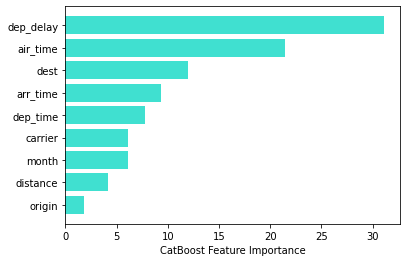

In [24]:
from matplotlib import pyplot as plt

sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(x.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

### Differences Between Models and My Reasoning

Although the obvious differences between the models have previously been noted, the difference in complexity, reproducibility, and run time of the previous linear model I created in R and this model are substantial. In this case, I have made significant pipeline improvements in comparison to my previous model. While the model presented in this project uses a more complex algorithm to create predictions, I believe the nature of the algorithm is more reproducible than my previous model in a few ways. In order to clean the dataset and split it into testing and validating sets, my pipeline was able to do that with 8 simple, easy to follow lines of code. It took me just as many lines to clean the dataset in my previous model and I had not even split the data in testing and validating sets. Further, the actual evaluation on the validation set in this pipeline was imbedded into the learning process of the model. If there was overfitting detected, the model would be shrunk to an iteration where it was not overfit. Having not had done that in my previous model, it would have taken much more effort and may have been confusing to relay in a pipeline explanation, thus making this model more reproducible. While complex, this pipeline and included model have the capability of completing tasks that I would have needed to spend much more time on in R and in my previous model. When looking at the run time of this model in comparision to my previous, the number of iterations makes the learning process long, but not as long as it would take my linear model to fit. Being able to run 1000 learning and evaluating iterations with tuned hyperparameters in less time than it took my linear model with the added interaction terms makes the current model and algorithm better overall.

### Modifications and Extensions

In order to improve upon my method, I first need to choose my hyperparameters that are included in the CatBoostRegressor() function to tune and add them to my tuning process. It was mentioned previously that the hyperparamter tuning process drastically improved the performance of the model, lowering the RMSLE by a large amount. Further tuning and testing of new hyperparamaters is a great way to improve this model further. Another significant way to improve this model would be to utilize external datasets to add even more features to the model. One external dataset that I had looked into using and had been used by multiple other students was the weather dataset that coincides with the flights dataset. Being able to use other features such as temperature, windspeed, and visibility, among the many others included in that dataset, would surely improve my model and allow to perform even better, minimizing the RMSLE to an even lower value.

